# Titanic: Exploratory Data Analysis

Author: Carlos Moreno Morera
Last review: 14 May 2021

## Introduction
This notebook carries out an exploratory data analysis of the [Kaggle's Titanic competition](https://www.kaggle.com/c/titanic). The data of this problem has been split into two groups: training set (stored in *train.csv*) and test set (stored in *test.csv*). Both have the following features:

| Name     | Description                                           | Key             |
|----------|-------------------------------------------------------|-----------------|
| PassengerId | Unique passenger identifier                        |                 |
| Survival | Determines whether the passenger survived the tragedy | 0 = No, 1 = Yes |
| Pclass   | Ticket class. It is a proxy for socio-economic status (1st = upper, 2nd = middle, 3d = lower)| 1 = st, 2 = 2nd, 3 = 3rd|
| Name     | Name of the passenger                                 |                 |
| Sex      | Sex                                                   |                 |
| Age      | Age in years (it is fractional if less than 1). If it is stimated, is in form of xx.5 |                 |
| SibSp    | Number of siblings (brother, sister, stepbrother and stepsister) and spouses (husband and wife) aboard the Titanic |          |
| Parch    | Number of parents and children (daughter, son, stepdaughter and stepson) aboard the Titanic |        |
| Ticket   | Ticket number                                         |                 |
| Fare     | Passenger fare                                        |                 |
| Cabin    | Cabin number                                          |                 |
| Embarked | Port of embarkation                                   | C = Cherbourg, Q = Queenstown, S = Southampton |

The aim of this competition is to develop a model that is able to predict the survival of a passenger given all other features. For this reason, we will focus most of the analysis on the target feature and how the other characteristics relate to it. In addition, since we already have the division of the dataset between test and training, we will compare the results of both to make sure that they are properly distributed.

Let's start by looking at the structure of the data:

In [18]:
import pandas as pd

#Read data
df_train = pd.read_csv("data/train.csv", index_col = "PassengerId")
df_test = pd.read_csv("data/test.csv", index_col = "PassengerId")

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [55]:
def print_table_of_column_property(title, len_title, series_train, series_test, 
                                   get_table_val = lambda val, is_train = True: str(val)):
    print(f'{"Column name":<15} {"Train " + title:<{len_title}} Test {title}')
    
    #Print each column of each DataFrame
    for col_name, col_prop in series_train.iteritems():
        if col_name in series_test:
            print(f'{col_name:<15} {get_table_val(col_prop):<{len_title}} {get_table_val(series_test.at[col_name], False)}')
        else:
            print(f'{col_name:<15} {get_table_val(col_prop):<{len_title}}')

# Use the function to print a table with the types of each column
print_table_of_column_property("type", 15, df_train.dtypes, df_test.dtypes)

Column name     Train type      Test type
Survived        int64          
Pclass          int64           int64
Name            object          object
Sex             object          object
Age             float64         float64
SibSp           int64           int64
Parch           int64           int64
Ticket          object          object
Fare            float64         float64
Cabin           object          object
Embarked        object          object


A suitable and necessary check is, as can be seen, the comparison of the column types of both sets. As expected, all the features match in type and we can only differentiate the datasets in that the test set does not have the column indicating whether the passenger survived.

## First steps

At first we are going to study simple properties of our datasets such as the amount of missing values per feature and the existence of duplicate rows. Let's start with the study of missing values:

### Missing values

In [60]:
LEN_TRAIN = len(df_train)
LEN_TEST = len(df_test)

def get_mv_string(mv, is_train = True):
    return mv if mv == 0 else f"{mv:<3} ({round(mv*100/(LEN_TRAIN if is_train else LEN_TEST), 2)}%)"

print_table_of_column_property("missing values", 25, df_train.isnull().sum(), df_test.isnull().sum(), get_mv_string)

Column name     Train missing values      Test missing values
Survived        0                        
Pclass          0                         0
Name            0                         0
Sex             0                         0
Age             177 (19.87%)              86  (20.57%)
SibSp           0                         0
Parch           0                         0
Ticket          0                         0
Fare            0                         1   (0.24%)
Cabin           687 (77.1%)               327 (78.23%)
Embarked        2   (0.22%)               0


As we can see, there are quite a few missing values in `Age` feature. They represent approximately 20% of each dataset. This is an important fact to take into account when developing our predictive model.

Another insight that cannot be overlooked is the immense amount of missing values in the `Cabin` feature (more than 75% of elements are uninformed). In fact, it is not possible to obtain statistically significant results on this column given this large amount of missing values.

Finally, there are some missing values in the `Fare` and `Embarked` features. However, as there are so few cases (one and two respectively), it is possible to come up with a solution to overcome this problem.

### Unique values

In [61]:
print_table_of_column_property("unique values", 20, df_train.nunique(), df_test.nunique())

Column name     Train unique values  Test unique values
Survived        2                   
Pclass          3                    3
Name            891                  418
Sex             2                    2
Age             88                   79
SibSp           7                    7
Parch           7                    8
Ticket          681                  363
Fare            248                  169
Cabin           147                  76
Embarked        3                    3


## Comparison between test and training data

The aim of this comparison is to know the possible differences between both sets, so that if there are features with different properties (less balanced, with higher skewness, ...) we can take this into account when developing our model.

### Descriptive statistics of quantitative data

Now that we have carried out a first approximation with each of the samples, we proceed to the comparison of the different descriptive (sample) statistics both to understand the characteristics of each of them and to begin to determine whether there has been randomness in generating them.

In [20]:
desc_train = df_train.describe()
desc_test = df_test.describe()
description = pd.merge(desc_train, desc_test, left_index=True, right_index=True, suffixes=('', '_test'))
description.reindex(sorted(description.columns), axis=1)

,Age,Age_test,Fare,Fare_test,Parch,Parch_test,Pclass,Pclass_test,SibSp,SibSp_test,Survived
count,714.000000,332.000000,891.000000,417.000000,891.000000,418.000000,891.000000,418.000000,891.000000,418.000000,891.000000
mean,29.699118,30.272590,32.204208,35.627188,0.381594,0.392344,2.308642,2.265550,0.523008,0.447368,0.383838
std,14.526497,14.181209,49.693429,55.907576,0.806057,0.981429,0.836071,0.841838,1.102743,0.896760,0.486592
min,0.420000,0.170000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,20.125000,21.000000,7.910400,7.895800,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,28.000000,27.000000,14.454200,14.454200,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000
75%,38.000000,39.000000,31.000000,31.500000,0.000000,0.000000,3.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,76.000000,512.329200,512.329200,6.000000,9.000000,3.000000,3.000000,8.000000,8.000000,1.000000


After observing the table above, at first sight, both samples seem to have very similar descriptive statistics, in fact, as can be seen in the following table, the difference between each of them is negligible:

In [23]:
abs(desc_train[[col_name for col_name in desc_train.columns if col_name != "Survived"]] - desc_test)

,Pclass,Age,SibSp,Parch,Fare
count,473.000000,382.000000,473.000000,473.000000,474.000000
mean,0.043092,0.573473,0.075639,0.010751,3.422981
std,0.005766,0.345288,0.205984,0.175372,6.214148
min,0.000000,0.250000,0.000000,0.000000,0.000000
25%,1.000000,0.875000,0.000000,0.000000,0.014600
50%,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.500000
max,0.000000,4.000000,0.000000,3.000000,0.000000


The most notable difference is found in `Fare`, both in the mean and in the standard deviation. However, it is worth noting that both in this column and in the rest, the minimum and maximum values and the vast majority of the quartiles coincide in both sets. Since these values are the same, it will not be necessary to calculate and compare the ranges and interquartile ranges for each of the samples. These results are quite favourable for the hypothesis of the existence of randomness in the selection of the two samples.

Another fact is that the training sample is more than twice the size of the test sample. Thus, the fist corresponds to approximately 68.07% of the total data set (considering the union of the two samples), while the latter represents approximately 31.93%.

### Comparing qualitative data

Having studied the quantitative data, let us look at the differences that appear in the qualitative data between the two samples. To do this, we will represent a bar chart for each field in which the percentage of each of the classes in each sample can be seen.

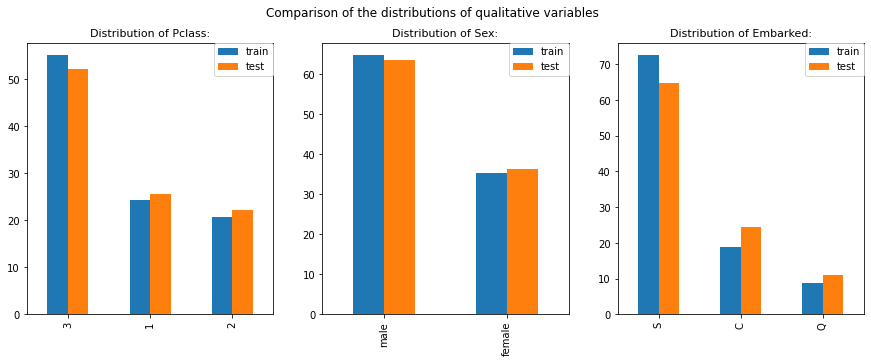

In [59]:
import matplotlib.pyplot as plt
import math

QUAL_COL = ["Pclass", "Sex", "Embarked"]
num_rows = math.ceil(len(QUAL_COL)/3)
ind = 0

fig = plt.figure(figsize=(15, 5))
fig.suptitle("Comparison of the distributions of qualitative variables")
for c in QUAL_COL:
    class_per = []
    for (df, name) in [(df_train, "train"), (df_test, "test")]:
        counts = df[c].value_counts()
        total_sum = sum(counts)
        
        class_per.append(counts.map(lambda amount: 100 * (amount/total_sum), na_action='ignore'))
        class_per[-1]["Key"] = name
        
    ax = plt.subplot(num_rows, 3, ind+1)
    ind += 1
    pd.concat(class_per, keys=["train", "test"]).unstack(level = 0).drop(labels = "Key").plot.bar(ax=ax)\
        .legend(bbox_to_anchor=(1, 1), borderaxespad=0)
    plt.title(f"Distribution of {c}:", size=11)

plt.show()

Due to their big amount of different values, the columns `Name`, `Ticket` and `Cabin`, have not been taken into account for this comparison. Besides, as we have previously study, `Pclass` feature has been included because, in practice, it is qualitative.